In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit
import random
random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test_df = pd.read_csv('SRER21_dataset_v1.csv', na_values='?').dropna()
train_df = pd.read_csv('JORN17_dataset_v1.csv', na_values='?').dropna()
bigtest1_df = pd.read_csv('SRER21_pred.csv', na_values='?')
del bigtest1_df["Veg_class"]
bigtest_df = bigtest1_df.dropna()
bigtest_df["Veg_class"] = ""
bigtest_df

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/4151195241.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigtest_df["Veg_class"] = ""


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,1,1,1,15.8,3.36,0.000000,0.207123,0.167813,0.335815,0.212394,0.186196,0.291992,0.350170,0.315030,0.463047,0.208236,0.183683,0.282265,
1,2,2,2,24.0,6.93,1.000000,0.319239,0.334353,0.347863,0.275198,0.279712,0.299364,0.440041,0.453643,0.467307,0.263501,0.269123,0.285889,
2,3,3,3,3486.2,1942.77,0.120091,0.014902,-0.002058,0.388165,0.155599,0.143094,0.441733,0.199209,0.184422,0.503913,0.155182,0.144957,0.397375,
3,4,4,4,31.6,9.23,1.000000,0.419381,0.443782,0.507713,0.344481,0.337613,0.405390,0.527309,0.540501,0.596006,0.326518,0.321309,0.381685,
4,5,5,5,31.8,11.82,1.000000,0.465333,0.440134,0.565654,0.335128,0.329047,0.380148,0.562001,0.551508,0.639035,0.321567,0.314126,0.359091,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861995,1861997,1861997,1861997,13.0,3.40,1.333333,0.559468,0.584926,0.644338,0.464707,0.490516,0.496172,0.647694,0.664661,0.698624,0.431897,0.450168,0.450804,
1861996,1861998,1861998,1861998,11.0,2.69,1.000000,0.613639,0.613639,0.640257,0.499447,0.499447,0.511589,0.681893,0.681893,0.699795,0.455272,0.455272,0.464184,
1861997,1861999,1861999,1861999,10.6,2.72,0.000000,0.358293,0.363512,0.409451,0.337635,0.338354,0.372314,0.521439,0.526092,0.559708,0.343056,0.344207,0.372384,
1861998,1862000,1862000,1862000,10.8,2.16,0.000000,0.289427,0.289427,0.289427,0.254500,0.254500,0.254500,0.443562,0.443562,0.443562,0.258075,0.258075,0.258075,


In [6]:
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.053401048999999645 seconds ---

Accuracy of each fold: 
 [0.7188679245283018, 0.690566037735849, 0.7622641509433963, 0.7452830188679245, 0.7315689981096408]
Avg accuracy: 0.7297100260370226
Std of accuracy : 
0.024312745285325944

[[  53  624]
 [  92 1880]]

              precision    recall  f1-score   support

   non-woody       0.37      0.08      0.13       677
       woody       0.75      0.95      0.84      1972

    accuracy                           0.73      2649
   macro avg       0.56      0.52      0.48      2649
weighted avg       0.65      0.73      0.66      2649

0.07828655834564253
0.9533468559837728
0.36551724137931035
0.12895377128953772


In [7]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 108 2122]
 [  20 4555]]

              precision    recall  f1-score   support

   non-woody       0.84      0.05      0.09      2230
       woody       0.68      1.00      0.81      4575

    accuracy                           0.69      6805
   macro avg       0.76      0.52      0.45      6805
weighted avg       0.74      0.69      0.57      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.6852314474650992
sens  0.9956284153005465
spec  0.0484304932735426
prec  0.84375
f1_score  0.0916030534351145


In [8]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/1720852970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigtest_df["Veg_class"] = finalPredicted


In [9]:
bigtest_df.head(n=75)

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,1,1,1,15.8,3.36,0.000000,0.207123,0.167813,0.335815,0.212394,0.186196,0.291992,0.350170,0.315030,0.463047,0.208236,0.183683,0.282265,woody
1,2,2,2,24.0,6.93,1.000000,0.319239,0.334353,0.347863,0.275198,0.279712,0.299364,0.440041,0.453643,0.467307,0.263501,0.269123,0.285889,woody
2,3,3,3,3486.2,1942.77,0.120091,0.014902,-0.002058,0.388165,0.155599,0.143094,0.441733,0.199209,0.184422,0.503913,0.155182,0.144957,0.397375,woody
3,4,4,4,31.6,9.23,1.000000,0.419381,0.443782,0.507713,0.344481,0.337613,0.405390,0.527309,0.540501,0.596006,0.326518,0.321309,0.381685,woody
4,5,5,5,31.8,11.82,1.000000,0.465333,0.440134,0.565654,0.335128,0.329047,0.380148,0.562001,0.551508,0.639035,0.321567,0.314126,0.359091,woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,71,71,13.2,3.74,1.000000,0.393732,0.393732,0.415469,0.317757,0.317757,0.322081,0.506312,0.506312,0.519724,0.304152,0.304152,0.306800,woody
71,72,72,72,16.2,2.98,1.000000,0.310143,0.310143,0.380488,0.314589,0.314589,0.331852,0.450113,0.450113,0.500650,0.302977,0.302977,0.316667,woody
72,73,73,73,23.8,10.61,0.000000,0.058388,0.025142,0.272548,0.186139,0.160347,0.342324,0.237574,0.208232,0.420424,0.183174,0.160296,0.321483,non-woody
73,74,74,74,233.8,224.39,0.023697,0.218338,0.209522,0.557677,0.288354,0.284696,0.521968,0.373289,0.366884,0.651667,0.275636,0.275797,0.476357,woody


In [10]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded = woodyarea1/totalarea1 * 100\nprint(needed)\n'

In [11]:
"""
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)
"""

'\nwoodyarea4 = 0\nnonwoodyarea4 = 0\ntotalarea4 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex8:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex9[k]:\n                if l == "woody":\n                    woodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea4 += test_df.iat[j,4]\n                    totalarea4 += test_df.iat[j,4]\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nFWC4 = woodyarea4/totalarea4 * 100\n                    \nprint(FWC4)\n'

In [12]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)


elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 0.8800613169999991 seconds ---

Accuracy of each fold: 
 [0.7283018867924528, 0.7150943396226415, 0.7735849056603774, 0.7566037735849057, 0.7277882797731569]
Avg accuracy: 0.7402746370867068
Std of accuracy : 
0.02149194239791228

[[ 101  576]
 [ 112 1860]]

              precision    recall  f1-score   support

   non-woody       0.47      0.15      0.23       677
       woody       0.76      0.94      0.84      1972

    accuracy                           0.74      2649
   macro avg       0.62      0.55      0.54      2649
weighted avg       0.69      0.74      0.69      2649

0.14918759231905465
0.9432048681541582
0.47417840375586856
0.22696629213483147


In [13]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 322 1908]
 [  59 4516]]

              precision    recall  f1-score   support

   non-woody       0.85      0.14      0.25      2230
       woody       0.70      0.99      0.82      4575

    accuracy                           0.71      6805
   macro avg       0.77      0.57      0.53      6805
weighted avg       0.75      0.71      0.63      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7109478324761205
sens  0.987103825136612
spec  0.14439461883408072
prec  0.8451443569553806
f1_score  0.24664879356568367


In [14]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted
bigtest_df.head(n=50)

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/749526484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigtest_df["Veg_class"] = finalPredicted


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,1,1,1,15.8,3.36,0.000000,0.207123,0.167813,0.335815,0.212394,0.186196,0.291992,0.350170,0.315030,0.463047,0.208236,0.183683,0.282265,woody
1,2,2,2,24.0,6.93,1.000000,0.319239,0.334353,0.347863,0.275198,0.279712,0.299364,0.440041,0.453643,0.467307,0.263501,0.269123,0.285889,woody
2,3,3,3,3486.2,1942.77,0.120091,0.014902,-0.002058,0.388165,0.155599,0.143094,0.441733,0.199209,0.184422,0.503913,0.155182,0.144957,0.397375,non-woody
3,4,4,4,31.6,9.23,1.000000,0.419381,0.443782,0.507713,0.344481,0.337613,0.405390,0.527309,0.540501,0.596006,0.326518,0.321309,0.381685,woody
4,5,5,5,31.8,11.82,1.000000,0.465333,0.440134,0.565654,0.335128,0.329047,0.380148,0.562001,0.551508,0.639035,0.321567,0.314126,0.359091,woody
5,6,6,6,61.0,15.73,1.000000,0.388299,0.392301,0.558201,0.340119,0.329843,0.417976,0.506015,0.510729,0.640907,0.323304,0.316266,0.390960,woody
6,7,7,7,11.6,2.33,0.666667,0.435153,0.501700,0.508019,0.350849,0.352031,0.410666,0.542913,0.591679,0.603258,0.334208,0.337273,0.385493,woody
7,8,8,8,55.2,36.59,0.235294,0.094267,0.073039,0.375784,0.202749,0.197483,0.331198,0.270160,0.256369,0.487022,0.200563,0.196467,0.316553,woody
8,9,9,9,33.4,10.51,0.600000,0.299233,0.296807,0.441675,0.286510,0.296106,0.360563,0.431976,0.435374,0.545392,0.275263,0.284235,0.340146,woody
9,10,10,10,64.0,32.91,0.903226,0.382419,0.383198,0.510562,0.302928,0.308982,0.372048,0.496885,0.503172,0.601409,0.291949,0.297567,0.354577,woody


In [15]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nprint(woodyarea1/totalarea1 * 100)\n\nneeded2 = woodyarea1/totalarea1 * 100\nprint(needed2)\n'

In [16]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex1:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex2[k]:\n                if l == "woody":\n                    woodyarea1 += test_df.iat[j,4]\n                    totalarea1 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea1 += test_df.iat[j,4]\n                    totalarea1 += test_df.iat[j,4]\n\n                    \nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nFWC = woodyarea1/totalarea1 * 100\n                    \nprint(FWC)\n'

In [17]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 2.386254338999999 seconds ---

Accuracy of each fold: 
 [0.6264150943396226, 0.6547169811320754, 0.6245283018867924, 0.5867924528301887, 0.6162570888468809]
Avg accuracy: 0.6217419838071121
Std of accuracy : 
0.021764676736874607

[[ 571  106]
 [ 896 1076]]

              precision    recall  f1-score   support

   non-woody       0.39      0.84      0.53       677
       woody       0.91      0.55      0.68      1972

    accuracy                           0.62      2649
   macro avg       0.65      0.69      0.61      2649
weighted avg       0.78      0.62      0.64      2649

0.843426883308715
0.5456389452332657
0.3892297205180641
0.5326492537313433


In [18]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[ 475 1755]
 [ 239 4336]]

              precision    recall  f1-score   support

   non-woody       0.67      0.21      0.32      2230
       woody       0.71      0.95      0.81      4575

    accuracy                           0.71      6805
   macro avg       0.69      0.58      0.57      6805
weighted avg       0.70      0.71      0.65      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.7069801616458486
sens  0.9477595628415301
spec  0.21300448430493274
prec  0.665266106442577
f1_score  0.3226902173913044


In [19]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/1720852970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigtest_df["Veg_class"] = finalPredicted


In [20]:
bigtest_df.head(n=60)

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,1,1,1,15.8,3.36,0.000000,0.207123,0.167813,0.335815,0.212394,0.186196,0.291992,0.350170,0.315030,0.463047,0.208236,0.183683,0.282265,woody
1,2,2,2,24.0,6.93,1.000000,0.319239,0.334353,0.347863,0.275198,0.279712,0.299364,0.440041,0.453643,0.467307,0.263501,0.269123,0.285889,woody
2,3,3,3,3486.2,1942.77,0.120091,0.014902,-0.002058,0.388165,0.155599,0.143094,0.441733,0.199209,0.184422,0.503913,0.155182,0.144957,0.397375,woody
3,4,4,4,31.6,9.23,1.000000,0.419381,0.443782,0.507713,0.344481,0.337613,0.405390,0.527309,0.540501,0.596006,0.326518,0.321309,0.381685,woody
4,5,5,5,31.8,11.82,1.000000,0.465333,0.440134,0.565654,0.335128,0.329047,0.380148,0.562001,0.551508,0.639035,0.321567,0.314126,0.359091,woody
5,6,6,6,61.0,15.73,1.000000,0.388299,0.392301,0.558201,0.340119,0.329843,0.417976,0.506015,0.510729,0.640907,0.323304,0.316266,0.390960,woody
6,7,7,7,11.6,2.33,0.666667,0.435153,0.501700,0.508019,0.350849,0.352031,0.410666,0.542913,0.591679,0.603258,0.334208,0.337273,0.385493,woody
7,8,8,8,55.2,36.59,0.235294,0.094267,0.073039,0.375784,0.202749,0.197483,0.331198,0.270160,0.256369,0.487022,0.200563,0.196467,0.316553,woody
8,9,9,9,33.4,10.51,0.600000,0.299233,0.296807,0.441675,0.286510,0.296106,0.360563,0.431976,0.435374,0.545392,0.275263,0.284235,0.340146,woody
9,10,10,10,64.0,32.91,0.903226,0.382419,0.383198,0.510562,0.302928,0.308982,0.372048,0.496885,0.503172,0.601409,0.291949,0.297567,0.354577,woody


In [21]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded3 = woodyarea1/totalarea1 * 100\nprint(needed3)\n'

In [22]:
"""
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)
"""

'\nwoodyarea2 = 0\nnonwoodyarea2 = 0\ntotalarea2 = 0\nstart_time = timeit.default_timer()\n\nfor i in testindex3:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex4[k]:\n                if l == "woody":\n                    woodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea2 += test_df.iat[j,4]\n                    totalarea2 += test_df.iat[j,4]\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nFWC2 = woodyarea2/totalarea2 * 100\n                    \nprint(FWC2)\n'

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [23]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.73773585 0.70377358 0.71698113 0.72075472 0.7221172 ]

Avg accuracy: 0.7202724970574599

K=2

Accuracy of each fold: 
 [0.66415094 0.68113208 0.66981132 0.64716981 0.66162571]

Avg accuracy: 0.6647779719656168

K=3

Accuracy of each fold: 
 [0.73207547 0.73018868 0.74716981 0.72641509 0.72589792]

Avg accuracy: 0.7323493954417376

K=4

Accuracy of each fold: 
 [0.72264151 0.72830189 0.72264151 0.71509434 0.69754253]

Avg accuracy: 0.7172443556728607

K=5

Accuracy of each fold: 
 [0.74339623 0.74528302 0.77358491 0.73584906 0.72967864]

Avg accuracy: 0.7455583692977137

K=6

Accuracy of each fold: 
 [0.71509434 0.71886792 0.75849057 0.73396226 0.71644612]

Avg accuracy: 0.7285722438206654

K=7

Accuracy of each fold: 
 [0.76603774 0.73962264 0.7754717  0.74528302 0.75425331]

Avg accuracy: 0.7561336804936334

K=8

Accuracy of each fold: 
 [0.74339623 0.73207547 0.7490566  0.72830189 0.73534972]

Avg accuracy: 0.737635981025074

K=9

Accuracy of each fol

In [24]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = train_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = train_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 6.548198430999998 seconds ---

Accuracy of each fold: 
 [0.7547169811320755, 0.7396226415094339, 0.779245283018868, 0.7566037735849057, 0.7561436672967864]
Avg accuracy: 0.7572664693084139
Std of accuracy : 
0.01266943291121953

[[ 256  421]
 [ 222 1750]]

              precision    recall  f1-score   support

   non-woody       0.54      0.38      0.44       677
       woody       0.81      0.89      0.84      1972

    accuracy                           0.76      2649
   macro avg       0.67      0.63      0.64      2649
weighted avg       0.74      0.76      0.74      2649

0.37813884785819796
0.8874239350912779
0.5355648535564853
0.4432900432900433


In [25]:
Truth2 = []
Output2 = []
testing = test_df.iloc[:,-1]
model.fit(train_df.iloc[:,5:18],train_df.iloc[:,-1])
predicted = model.predict(test_df.iloc[:,5:18])
acc = accuracy_score(testing, predicted)
Truth2.extend(testing.values.reshape(testing.shape[0])); ## it is a list
Output2.extend(predicted);
print(confusion_matrix(Truth2, Output2))
print()
print(classification_report(Truth2, Output2))
cm2 = confusion_matrix(Truth2, Output2)
sensitivity = cm2[0][0]/(cm2[0][0]+cm2[0][1])
specificity = cm2[1][1]/(cm2[1][0]+cm2[1][1])
precision = (cm2[0][0])/(cm2[0][0]+cm2[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)
print("predicted",predicted)
print("acc",acc)
print("sens ",specificity)
print("spec ", sensitivity)
print("prec ", precision)
print("f1_score ", f1_score)

[[  90 2140]
 [  44 4531]]

              precision    recall  f1-score   support

   non-woody       0.67      0.04      0.08      2230
       woody       0.68      0.99      0.81      4575

    accuracy                           0.68      6805
   macro avg       0.68      0.52      0.44      6805
weighted avg       0.68      0.68      0.57      6805

predicted ['woody' 'woody' 'woody' ... 'woody' 'woody' 'woody']
acc 0.6790595150624541
sens  0.9903825136612022
spec  0.04035874439461883
prec  0.6716417910447762
f1_score  0.07614213197969544


In [26]:
finalPredicted = model.predict(bigtest_df.iloc[:,5:18])
bigtest_df["Veg_class"] = finalPredicted
bigtest_df.head(n=50)

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_4745/749526484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigtest_df["Veg_class"] = finalPredicted


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,Veg_class
0,1,1,1,15.8,3.36,0.000000,0.207123,0.167813,0.335815,0.212394,0.186196,0.291992,0.350170,0.315030,0.463047,0.208236,0.183683,0.282265,woody
1,2,2,2,24.0,6.93,1.000000,0.319239,0.334353,0.347863,0.275198,0.279712,0.299364,0.440041,0.453643,0.467307,0.263501,0.269123,0.285889,woody
2,3,3,3,3486.2,1942.77,0.120091,0.014902,-0.002058,0.388165,0.155599,0.143094,0.441733,0.199209,0.184422,0.503913,0.155182,0.144957,0.397375,non-woody
3,4,4,4,31.6,9.23,1.000000,0.419381,0.443782,0.507713,0.344481,0.337613,0.405390,0.527309,0.540501,0.596006,0.326518,0.321309,0.381685,woody
4,5,5,5,31.8,11.82,1.000000,0.465333,0.440134,0.565654,0.335128,0.329047,0.380148,0.562001,0.551508,0.639035,0.321567,0.314126,0.359091,woody
5,6,6,6,61.0,15.73,1.000000,0.388299,0.392301,0.558201,0.340119,0.329843,0.417976,0.506015,0.510729,0.640907,0.323304,0.316266,0.390960,woody
6,7,7,7,11.6,2.33,0.666667,0.435153,0.501700,0.508019,0.350849,0.352031,0.410666,0.542913,0.591679,0.603258,0.334208,0.337273,0.385493,woody
7,8,8,8,55.2,36.59,0.235294,0.094267,0.073039,0.375784,0.202749,0.197483,0.331198,0.270160,0.256369,0.487022,0.200563,0.196467,0.316553,woody
8,9,9,9,33.4,10.51,0.600000,0.299233,0.296807,0.441675,0.286510,0.296106,0.360563,0.431976,0.435374,0.545392,0.275263,0.284235,0.340146,woody
9,10,10,10,64.0,32.91,0.903226,0.382419,0.383198,0.510562,0.302928,0.308982,0.372048,0.496885,0.503172,0.601409,0.291949,0.297567,0.354577,woody


In [27]:
"""
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)
"""

'\nwoodyarea1 = 0\nnonwoodyarea1 = 0\ntotalarea1 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        totalarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "woody":\n            woodyarea1 += test_df.iat[j,4]\n        if test_df.iat[j,-1] == "non-woody":\n            nonwoodyarea1 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nneeded4 = woodyarea1/totalarea1 * 100\nprint(needed4)\n'

In [28]:
"""
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)
"""

'\nwoodyarea3 = 0\nnonwoodyarea3 = 0\ntotalarea3 = 0\n\nstart_time = timeit.default_timer()\n\nfor i in testindex5:\n    for j in i:\n        for k in range(0,5):\n            for l in testindex6[k]:\n                if l == "woody":\n                    woodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n                if l == "non-woody":\n                    nonwoodyarea3 += test_df.iat[j,4]\n                    totalarea3 += test_df.iat[j,4]\n\nelapsed = timeit.default_timer() - start_time\nprint("---Run time is %s seconds ---" % elapsed)\nFWC3 = woodyarea3/totalarea3 * 100\n                    \nprint(FWC3)\n'

In [29]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.729710,0.024313,0.078287,0.953347,0.365517,0.128954,0.053401
LDA,0.740275,0.021492,0.149188,0.943205,0.474178,0.226966,0.880061
QDA,0.621742,0.021765,0.843427,0.545639,0.389230,0.532649,2.386254
KNN-CV,0.757266,0.012669,0.378139,0.887424,0.535565,0.443290,6.548198


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7297100260370226, 0.7402746370867068, 0.6217419838071121, 0.7572664693084139]
Sen[0.07828655834564253, 0.14918759231905465, 0.843426883308715, 0.37813884785819796]
Spec[0.9533468559837728, 0.9432048681541582, 0.5456389452332657, 0.8874239350912779]
P[0.36551724137931035, 0.47417840375586856, 0.3892297205180641, 0.5355648535564853]
F1[0.12895377128953772, 0.22696629213483147, 0.5326492537313433, 0.4432900432900433]


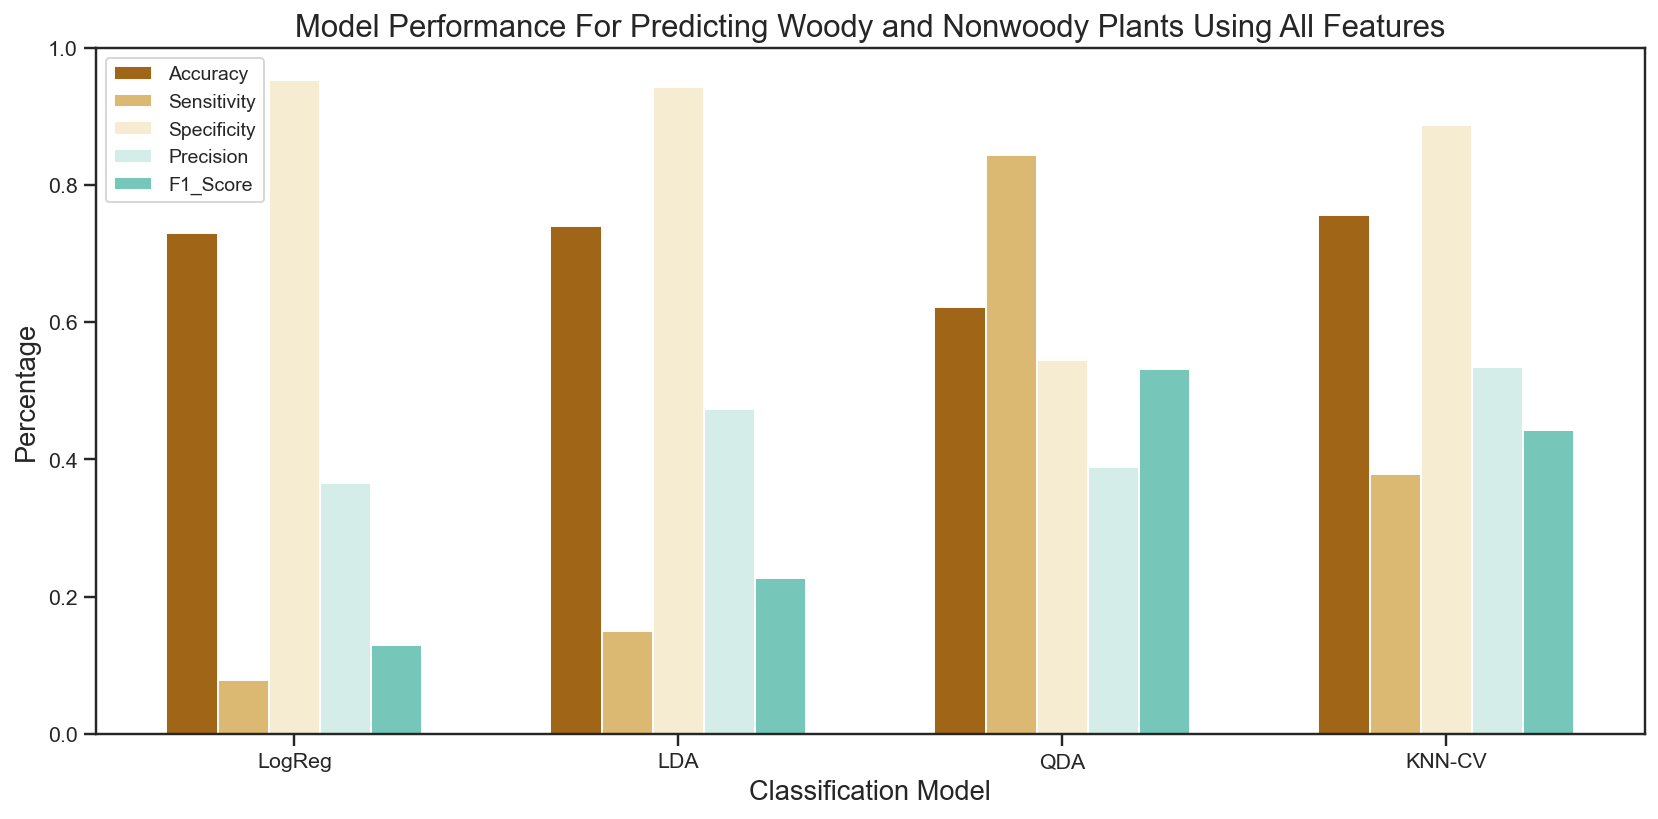

In [30]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

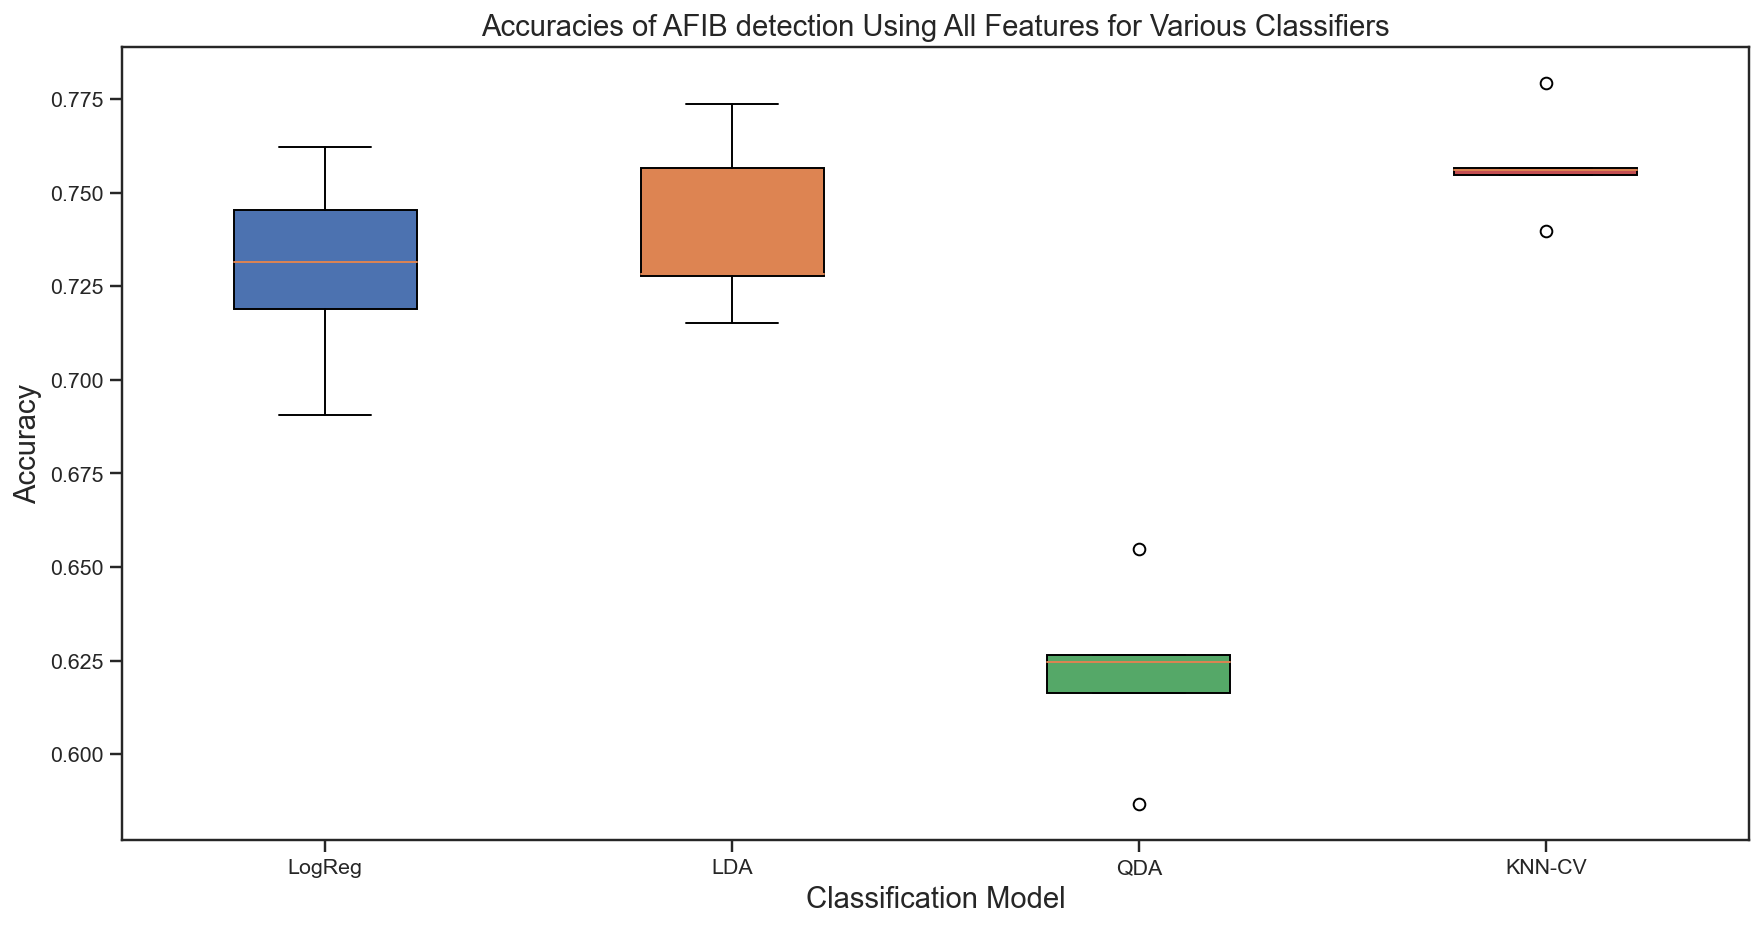

In [31]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [32]:
"""
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))
"""

'\nprint("Log reg act: " + str(needed))\nprint("Log reg pred: " + str(FWC4))\nprint("QDA act: " + str(needed2))\nprint("QDA pred: " + str(FWC2))\nprint("LDA act: " + str(needed3))\nprint("LDA pred: " + str(FWC))\nprint("KNN act: " + str(needed4))\nprint("KNN pred: " +str(FWC3))\n'

In [33]:
"""
Logerrorrate = abs((needed-FWC4)/needed) *100
QDAerrorrate = abs((needed-FWC2)/needed) *100
LDAerrorrate = abs((needed-FWC)/needed) *100
KNNerrorrate = abs((needed-FWC3)/needed) *100

print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))
"""

'\nLogerrorrate = abs((needed-FWC4)/needed) *100\nQDAerrorrate = abs((needed-FWC2)/needed) *100\nLDAerrorrate = abs((needed-FWC)/needed) *100\nKNNerrorrate = abs((needed-FWC3)/needed) *100\n\nprint("log ER = " + str(Logerrorrate))\nprint("QDA ER = " + str(QDAerrorrate))\nprint("LDA ER = " + str(LDAerrorrate))\nprint("KNN ER = " + str(KNNerrorrate))\n'